LSMTree {'metric': 'snapshot_aggr', 'value': 0.020014047622680664, 'write_volume': 1.00001}
LSMTree {'metric': 'snapshot_aggr', 'value': 0.03961753845214844, 'write_volume': 2.00002}
LSMTree {'metric': 'snapshot_aggr', 'value': 0.10401582717895508, 'write_volume': 3.00003}
LSMTree {'metric': 'snapshot_aggr', 'value': 0.12402176856994629, 'write_volume': 4.00004}
LSMTree {'metric': 'snapshot_aggr', 'value': 0.14384770393371582, 'write_volume': 5.00005}
LSMTree {'metric': 'snapshot_aggr', 'value': 0.2082805633544922, 'write_volume': 6.00006}
LSMTree {'metric': 'snapshot_aggr', 'value': 0.23375558853149414, 'write_volume': 7.00007}
LSMTree {'metric': 'snapshot_aggr', 'value': 0.253800630569458, 'write_volume': 8.00008}
LSMTree {'metric': 'snapshot_aggr', 'value': 0.445035457611084, 'write_volume': 9.00009}
LSMTree {'metric': 'snapshot_aggr', 'value': 0.4652745723724365, 'write_volume': 10.0001}
LSMTree {'metric': 'snapshot_aggr', 'value': 0.4852597713470459, 'write_volume': 11.00011}
LSMT

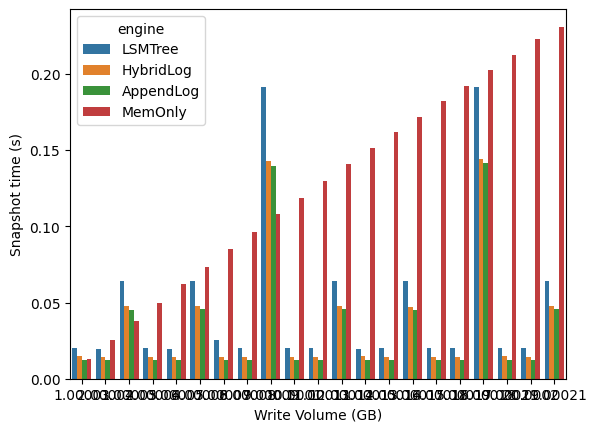


\begin{figure}[h]
    \centering
    \includegraphics[width=0.25\textwidth]{snapshot.png}
    \caption{snapshot.png}
    \label{fig:snapshot.png}
\end{figure}



In [13]:
import sys
sys.path.append('..')
from utils import *
from distributions import Uniform, Zipfian, HotSet
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathReplica, SimpleReplica

import seaborn as sns
import matplotlib.pyplot as plt


def measure_snapshot_time(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    rng = Random(1)
    klen = 2
    vlen = 8
    start = 1_000_000_000
    incr = 1_000
    n = 20

    size_so_far = 0
    aggr_time = 0

    for _ in range(incr):
        db[rng.randbytes(klen)] = rng.randbytes(vlen)
    with Timer() as t:
        db.snapshot()
    size_so_far += start + incr * (klen + vlen)
    aggr_time += float(t)
    row = {'metric': 'snapshot', 'value': float(t), 'write_volume': size_so_far / 1000000000}
    res.append(row)
    row = {'metric': 'snapshot_aggr', 'value': aggr_time, 'write_volume': size_so_far / 1000000000}
    print(db.name, row)
    res.append(row)

    for _ in range(n):
        for _ in range(incr):
            db[rng.randbytes(klen)] = rng.randbytes(vlen)
        with Timer() as t:
            db.snapshot()
        size_so_far += start + incr * (klen + vlen)
        aggr_time += float(t)
        row = {'metric': 'snapshot', 'value': float(t), 'write_volume': size_so_far / 1000000000}
        res.append(row)
        row = {'metric': 'snapshot_aggr', 'value': aggr_time, 'write_volume': size_so_far / 1000000000}
        print(db.name, row)
        res.append(row)

    return res

latency = 10**(-6)
df = run(
    [2], [8], [1], [1],
    [Uniform], [{'seed': [1]}],
    [LSMTree, HybridLog, AppendLog, MemOnly], [{
        'auto_push': [False],
        'max_runs_per_level': [3],
        'density_factor': [10],
        'memtable_bytes_limit': [1_000_000],
        'replica': [SimpleReplica('./benchmark_data_' + LSMTree.name, '/tmp/remote', network_latency_per_byte=latency)]
    },
    {
        'auto_push': [False],
        'max_runs_per_level': [3],
        'mem_segment_len': [210_000],
        'ro_lag_interval': [100_000],
        'flush_interval': [100_000],
        'hash_index': ['dict'],
        'compaction_enabled': [False],
        'replica': [SimpleReplica('./benchmark_data_' + HybridLog.name, '/tmp/remote', network_latency_per_byte=latency)]
    },
    {
        'auto_push': [False],
        'max_runs_per_level': [3],
        'threshold': [1_000_000],
        'replica': [SimpleReplica('./benchmark_data_' + AppendLog.name, '/tmp/remote', network_latency_per_byte=latency)]
    },
    {
        'replica': [SimpleReplica('./benchmark_data_' + MemOnly.name, '/tmp/remote', network_latency_per_byte=latency)]
    }],
    [measure_snapshot_time], {}
)


data = df[['write_volume', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['snapshot'])]

barplot(data, 'write_volume', 'value', 'snapshot',
         hue='engine',
         X='Write Volume (GB)', Y='Snapshot time (s)',
         save=True, show=True)

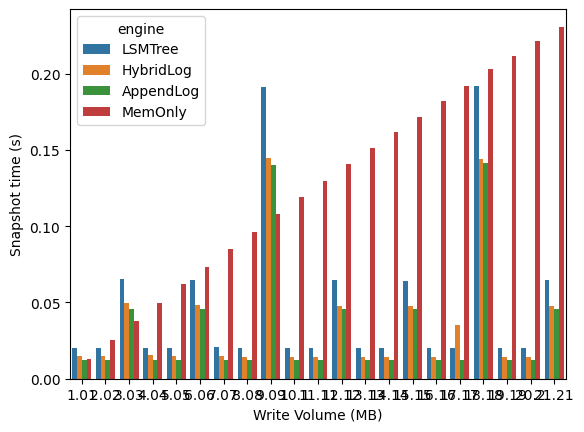


\begin{figure}[h]
    \centering
    \includegraphics[width=0.25\textwidth]{snapshot.png}
    \caption{snapshot.png}
    \label{fig:snapshot.png}
\end{figure}



In [5]:
data = df[['write_volume', 'metric', 'value', 'engine']]
data = data.iloc[:, 0:10]
data = data[data['metric'].isin(['snapshot'])]

barplot(data, 'write_volume', 'value', 'snapshot',
         hue='engine',
         X='Write Volume (MB)', Y='Snapshot time (s)',
         save=True, show=True)

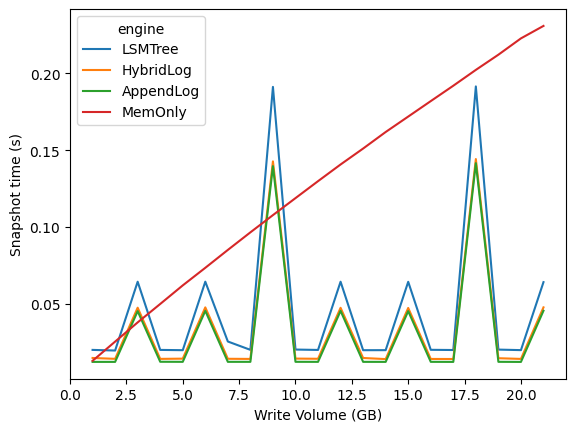


\begin{figure}[H]
    \centering
    \includegraphics[width=0.6\textwidth]{snapshot.png}
    \caption{snapshot}
    \label{fig:snapshot}
\end{figure}



In [14]:
data = df[['write_volume', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['snapshot'])]

lineplot(data, 'write_volume', 'value', 'snapshot',
         hue='engine',
         X='Write Volume (GB)', Y='Snapshot time (s)',
         save=True, show=True)

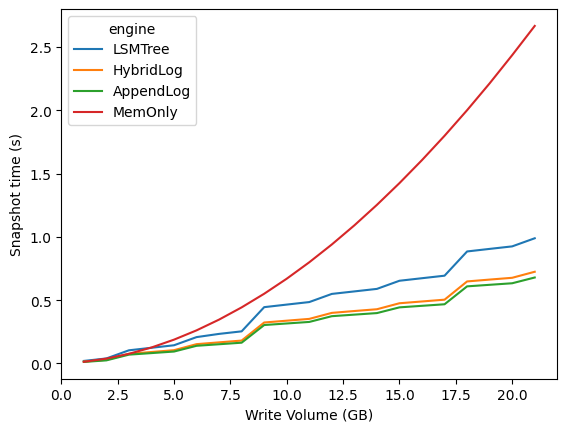


\begin{figure}[H]
    \centering
    \includegraphics[width=0.6\textwidth]{snapshot_aggr.png}
    \caption{snapshot_aggr}
    \label{fig:snapshot_aggr}
\end{figure}



In [16]:
data = df[['write_volume', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['snapshot_aggr'])]

lineplot(data, 'write_volume', 'value', 'snapshot_aggr',
         hue='engine',
         X='Write Volume (GB)', Y='Snapshot time (s)',
         save=True, show=True)